In [2]:
import pandas as pd
#import from pypi
import torch
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#local import
from CheXpert2.models.CNN import CNN
from CheXpert2.Metrics import Metrics
from CheXpert2.dataloaders.CXRLoader import CXRLoader
from CheXpert2 import names

In [4]:
def load_model() :
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
        warnings.warn("No gpu is available for the computation")
    models = [
        CNN("convnext_large_384_in22ft1k", img_size=384, channels=1, num_classes=18, pretrained=False,
            pretraining=False),
        #    CNN("convnext_base", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
        #    CNN("densenet201", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
        #    CNN("densenet201", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
    ]
    # model =  torch.nn.parallel.DistributedDataParallel(model)

    # api = wandb.Api()
    # run = api.run(f"ccsmtl2/Chestxray/{args.run_id}")
    # run.file("models_weights/convnext_base/DistributedDataParallel.pt").download(replace=True)
    weights = [
        "/mnt/c/Users/bejo2361/Downloads/CNN.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/convnext_base_2.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/densenet201.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/densenet201_2.pt",
    ]

    for model, weight in zip(models, weights):
        state_dict = torch.load(weight, map_location=torch.device(device))

        # from collections import OrderedDict
        # new_state_dict = OrderedDict()
        # for k, v in state_dict.items():
        #     name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
        #     new_state_dict[name] = v

        # model.load_state_dict(new_state_dict)
        model.load_state_dict(state_dict)
        # model = model.to(device)
        model.eval()

        return model

In [5]:
@torch.no_grad()
def infer_loop(model, loader, criterion, device):
    """

    :param model: model to evaluate
    :param loader: dataset loader
    :param criterion: criterion to evaluate the loss
    :param device: device to do the computation on
    :return: val_loss for the N epoch, tensor of concatenated labels and predictions
    """
    running_loss = 0
    results = [torch.tensor([]), torch.tensor([])]

    for inputs, labels in loader:
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = (
            inputs.to(device, non_blocking=True, memory_format=torch.channels_last),
            labels.to(device, non_blocking=True),
        )
        inputs = loader.dataset.preprocess(inputs)
        # forward + backward + optimize

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        outputs = torch.sigmoid(outputs)
        running_loss += loss.detach()

        if inputs.shape != labels.shape:  # prevent storing images if training unets
            results[1] = torch.cat(
                (results[1], outputs.detach().cpu()), dim=0
            )
            results[0] = torch.cat((results[0], labels.cpu()), dim=0)

        del (
            inputs,
            labels,
            outputs,
            loss,
        )  # garbage management sometimes fails with cuda


    return running_loss, results


In [6]:
criterion = torch.nn.BCEWithLogitsLoss()
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    warnings.warn("No gpu is available for the computation")

# ----- parsing arguments --------------------------------------


#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)
# ------loading test set --------------------------------------
#img_dir = os.environ["img_dir"]
img_dir = "/mnt/c/Users/bejo2361/PycharmProjects/IA-MED_IMG"
os.environ["DEBUG"]="True"
test_dataset = CXRLoader("Train",img_dir, img_size=384,channels=1,N=0,M=0,pretrain=False,datasets=["ChexPert"])

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
# ----------------loading model -------------------------------

model=load_model()
i=0

/tmp/ipykernel_1098/578706296.py:6: UserWarning: No gpu is available for the computation
  warnings.warn("No gpu is available for the computation")


Collected query for dataset Collection(Database(MongoClient(host=['10.128.107.212:27017'], document_class=dict, tz_aware=False, connect=True), 'Public_Images'), 'ChexPert')
Careful! The category Emphysema has 0 images!
Careful! The category Hernia has 0 images!
Careful! The category Infiltration has 0 images!
Careful! The category Mass has 0 images!
Careful! The category Nodule has 0 images!
Careful! The category Pneumo other has 0 images!


/tmp/ipykernel_1098/3945274470.py:6: UserWarning: No gpu is available for the computation
  warnings.warn("No gpu is available for the computation")


In [ ]:

#start.record()
import time
start = time.time()
running_loss, results = infer_loop(model=model, loader=test_loader, criterion=criterion, device=device)
#end.record()
end=time.time()
#torch.cuda.synchronize()
#print("time : ", start.elapsed_time(end))
print(end-start)
#plt.imshow(np.sum(heatmaps[0][0].detach().cpu().numpy(), axis=0))
#plt.savefig("heatmaps.png")

metric = Metrics(num_classes=18, names=names, threshold=np.zeros((18)) + 0.5)
metrics = metric.metrics()
metrics_results = {}
for key in metrics:
    pred = results[1].numpy()
    true = results[0].numpy().round(0)
    metric_result = metrics[key](true, pred)
    metrics_results[key] = metric_result

print(metrics_results)

                     preds  ground-truth
Opacity           0.472754           0.0
Air               0.407020           1.0
Liquid            0.372655           0.0
Cardiomegaly      0.110299           0.0
Lung Lesion       0.111351           0.0
Emphysema         0.000864           0.0
Edema             0.079177           0.0
Consolidation     0.183127           0.0
Atelectasis       0.248876           0.0
Pneumothorax      0.379091           1.0
Pleural Effusion  0.329299           0.0
Fracture          0.156652           0.0
Hernia            0.001291           0.0
Infiltration      0.001589           0.0
Mass              0.001439           0.0
Nodule            0.001632           0.0
Pneumo other      0.001366           0.0
No Finding        0.941366           1.0


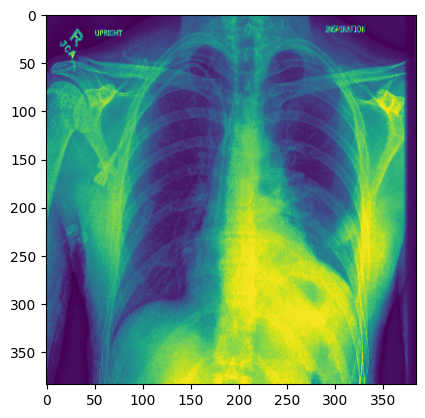

In [15]:

inputs,labels=test_dataset[i]
inputs=inputs[None,:,:,:]
inputs, labels = (
            inputs.to(device, non_blocking=True),
            labels.to(device, non_blocking=True),
        )

inputs = test_loader.dataset.preprocess(inputs)
# forward + backward + optimize

outputs = model(inputs)
loss = criterion(outputs.squeeze(), labels)
outputs = torch.sigmoid(outputs)

i+=1
plt.imshow(inputs.squeeze().numpy())
data=pd.DataFrame([outputs.detach().numpy().squeeze(),labels.numpy().squeeze()],columns=names,index=["preds","ground-truth"])

print(data.T)